# Bayes optimal classifier

## Generating 10 centroids for inputs (x's)

<IPython.core.display.Javascript object>


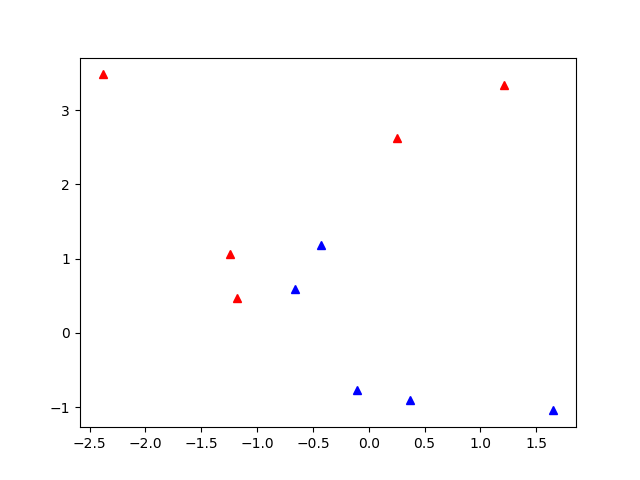

In [103]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np, pickle
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

# Generating 10 centroids for inputs (x's)
x_centroids_class1 = np.random.multivariate_normal(mean = [1, 0], cov = np.identity(2), size = 5) #Class 1 centroids
x_centroids_class2 = np.random.multivariate_normal(mean = [0, 1], cov = np.identity(2), size = 5) #Class 2 centroids
x_centroids = np.append(x_centroids_class1, x_centroids_class2, axis = 0) #All centroids

#plotting
ax = plt.subplots()[1]
ax.plot(x_centroids_class1[:, 0], x_centroids_class1[:, 1], marker = '^', linestyle = '', color = 'blue')
ax.plot(x_centroids_class2[:, 0], x_centroids_class2[:, 1], marker = '^', linestyle = '', color = 'red')

## Generating training data around centroids

In [104]:
np.random.multivariate_normal(mean = [1, 0], cov = [[1, 0], [0, 1]])

array([ 1.1049621 ,  0.46508064])

<IPython.core.display.Javascript object>


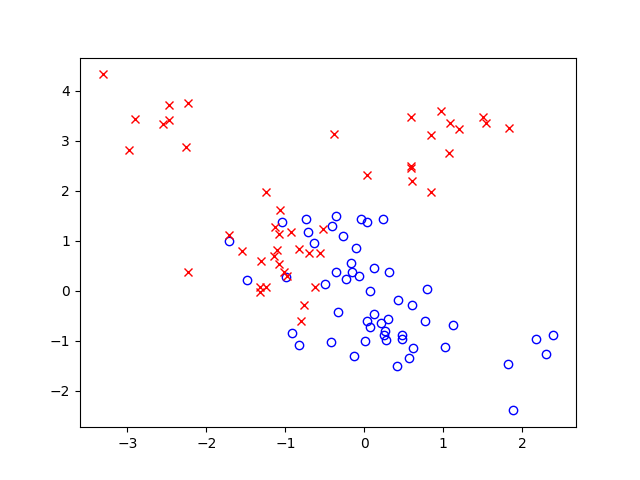

In [105]:
# Generating data around centroids

x_train, y_train = [], []

for _ in range(100):
    centroid_idx = np.random.choice(10) #sample i for m_i from 1 to 10
    x_train.append(np.random.multivariate_normal(mean = x_centroids[centroid_idx], cov = np.identity(2)/5.)) #sample xj
    if centroid_idx < 5: y_train.append(0) #if i in {0, ..4}, y = 0
    else: y_train.append(1) #if i in {5, ..9}, y = 1

x_train, y_train = np.array(x_train), np.array(y_train) #lists to arrays
#plotting 
ax = plt.subplots()[1]
ax.plot(x_train[y_train == 0, 0], x_train[y_train == 0, 1], linestyle = '', marker = 'o', color = 'blue', markerfacecolor = 'none')
ax.plot(x_train[y_train == 1, 0], x_train[y_train == 1, 1], linestyle = '', marker = 'x', color = 'red')



## Testing a linear model

We fit a linear model to the training data and draw the decision boundary (decision boundary is the subspace where y ~= 0.5). We highlight the false positive and false negatives in the model predictions and print the rates of both.

<IPython.core.display.Javascript object>


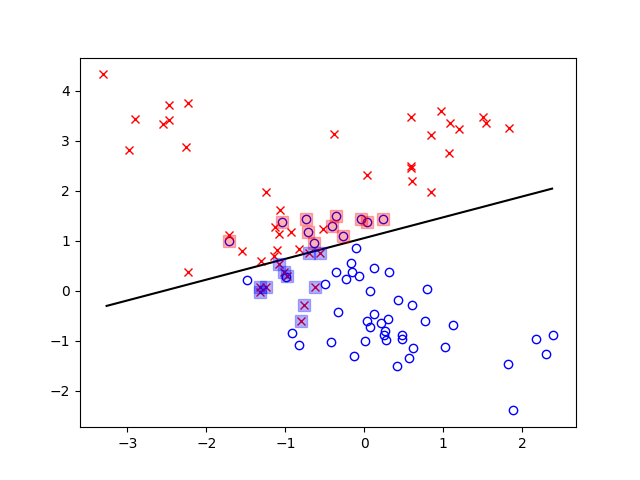

false positive rate = 20.7547169811% , false negative rate = 23.4042553191%


In [106]:
#train regression model
model = linear_model.LinearRegression()
model.fit(X = x_train, y = y_train)

#discretize x space
grid_x_points = 1000
x1_test_min, x1_test_max, x2_test_min, x2_test_max = np.amin(x_train[:, 0]), np.amax(x_train[:, 0]), np.amin(x_train[:, 1]), np.amax(x_train[:, 1])
x_test = np.dstack(np.mgrid[x1_test_min : x1_test_max : (x1_test_max - x1_test_min)/grid_x_points, x2_test_min : x2_test_max : (x2_test_max - x2_test_min)/grid_x_points]).reshape(-1, 2)

#predict y for x space and find x where y = 0.5
y_test = model.predict(X = x_test)
tolerance = 0.0001
x_boundary = x_test[np.abs(y_test - 0.5) <= tolerance]
#plotting 
ax = pickle.loads(pickle.dumps(ax))
ax.plot(x_boundary[:, 0], x_boundary[:, 1], linestyle = '-', marker = '', color = 'black')

# False positives and false negatives for training data
y_pred = np.vectorize(lambda y: 0 if y < 0.5 else 1)(model.predict(X = x_train)) #run model on training data
x_fp, x_fn = x_train[np.logical_and(y_pred == 1, y_train == 0)], x_train[np.logical_and(y_pred == 0, y_train == 1)]
#plotting
ax.plot(x_fp[:, 0], x_fp[:, 1], linestyle = '', marker = 's', color = 'red', alpha = 0.3, markersize = 8)
ax.plot(x_fn[:, 0], x_fn[:, 1], linestyle = '', marker = 's', color = 'blue', alpha = 0.3, markersize = 8)

#fp and fn rates
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
fp_rate, fn_rate = (fp + 0.)/(fp + tn)*100., (fn + 0.)/(fn + tp)*100.

print 'false positive rate = ' + str(fp_rate) + '% , false negative rate = ' + str(fn_rate) + '%'